### Single multi regression

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [117]:
data = pd.read_csv('../Data/processed_data.csv')

In [118]:
# get numeric feature

numerical_columns = data.select_dtypes(exclude='object').columns
numerical_features = numerical_columns.drop('rating')
numerical_features


Index(['enrollment', 'duration', 'instructor_rate'], dtype='object')

To know which feature affect the most, we evaluate depend on MSE. 
Select feature gives the lowest MSE

In [119]:
# out put column
output = 'rating'

# 1D array to save mse of each feature
mse_arr = np.zeros(3,)

# create a base model
base_model = LinearRegression()

X = data[numerical_features]
y = data[output]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

for i, feature in enumerate(numerical_features): 
    # clone base model
    model = clone(base_model)
    
    # Reshape feature to 2D array
    X_train_feature = X_train[feature].values.reshape(-1, 1)
    
    model.fit(X_train_feature, y_train)

    y_train_pred = model.predict(X_train_feature)
    mse_arr[i] = mean_squared_error(y_train, y_train_pred)

mse_df = pd.DataFrame({'Feature': numerical_features, 'MSE': mse_arr})
mse_df

,Feature,MSE
0,enrollment,0.057924
1,duration,0.058146
2,instructor_rate,0.037054


`instructor_rate` get the lowest MSE. Then we use it in single linear model

In [120]:
best_feature = 'instructor_rate'
model = clone(base_model)
    
X_train_feature = X_train[best_feature].values.reshape(-1, 1)

model.fit(X_train_feature, y_train)


LinearRegression()

Draw scatter plot for rating and instructor_rate

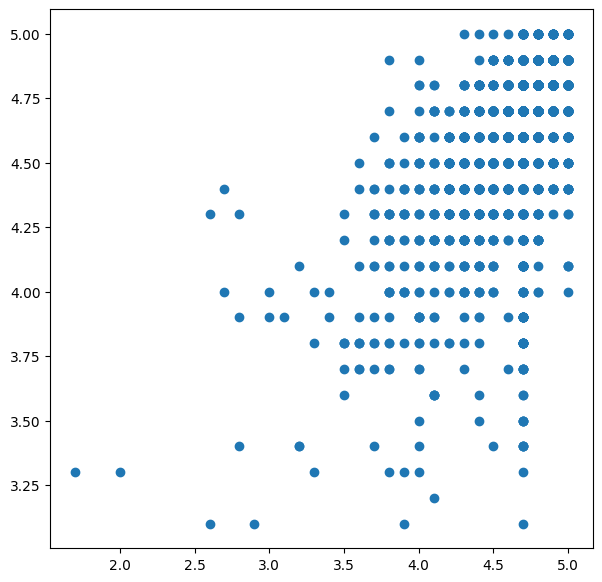

In [121]:
fig=plt.subplots(figsize=(7,7))
plt.scatter(X_train[[best_feature]], y_train)

In [122]:
# y= m*x + b
m = model.coef_
b = model.intercept_


Text(0, 0.5, 'predicted rating')

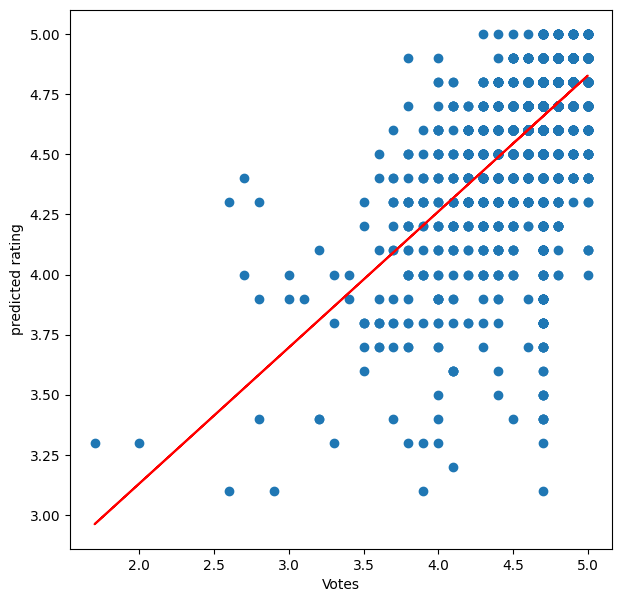

In [123]:
fig = plt.subplots(figsize=(7,7))
plt.scatter(X_train_feature, y_train)
plt.plot(X_train_feature, m*X_train_feature + b, color = 'red')
plt.xlabel("Votes")
plt.ylabel("predicted rating")

In [124]:
y_test_pred = model.predict(X_test[[best_feature]])
mse_test = mean_squared_error(y_train, y_train_pred)
print(f'MSE test data: {mse_test}')

MSE test data: 0.03705425769984717


Predict sample in test data

In [125]:
pd.DataFrame({'Predict': y_test_pred[10:16], 'Reality': y_test.values[10:16]})

,Predict,Reality
0,4.714582,4.7
1,4.714582,4.6
2,4.658007,4.8
3,4.601433,4.4
4,4.714582,4.7
5,4.375136,4.3


### Multi linear regression

In [126]:
numerical_columns = data.select_dtypes(exclude='object').columns
numerical_features = numerical_columns.drop('rating')
numerical_features
categorical_columns = data.select_dtypes(include='object').columns
categorical_features = categorical_columns.drop('name')
categorical_features

Index(['general', 'specify', 'language', 'level', 'instructor', 'offered by'], dtype='object')

Get feature columns and output column

In [127]:
X = data[numerical_features]
y = data['rating']

Split data into train, val, test

In [128]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X,y, train_size=0.7,random_state = 5)

X_test, X_val,  y_test, y_val = train_test_split(X_test_val,y_test_val, train_size=2/3,random_state = 5)


Hyper parameter here is degree of  polynomial. To tuning model, we will loop through degree from 1 to 20 to select which one give the best MSE

In [129]:
# define hyper parameter
degrees = np.arange(1,21,1)

# 1D array to store mse of train and val set
mse_train_arr = np.zeros((20,))
mse_val_arr = np.zeros((20,))

Loop all degrees then plot them

In [130]:
for i, degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree = degree), LinearRegression())
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    mse_train_arr[i] = mean_squared_error(y_train, y_train_pred)
    mse_val_arr[i] = mean_squared_error(y_val, y_val_pred)
    
    print(f'Degree: {degree}, Train MSE: {mse_train_arr[i]}, Validation MSE: {mse_val_arr[i]}')

Degree: 1, Train MSE: 0.03576392961534096, Validation MSE: 0.03499201365459201
Degree: 2, Train MSE: 0.035332065816067494, Validation MSE: 0.035383569133708465
Degree: 3, Train MSE: 0.03520763418047336, Validation MSE: 0.03603818502071233
Degree: 4, Train MSE: 0.05330888133329842, Validation MSE: 0.06041396749073782
Degree: 5, Train MSE: 0.05451741451827017, Validation MSE: 0.0612895320544777
Degree: 6, Train MSE: 0.05487833556796649, Validation MSE: 0.061603354787243325


Degree: 7, Train MSE: 0.05499238502382662, Validation MSE: 0.061690936113393886
Degree: 8, Train MSE: 0.05506321710458492, Validation MSE: 0.06172467121572174
Degree: 9, Train MSE: 0.05752702161676378, Validation MSE: 0.06252260930793371
Degree: 10, Train MSE: 0.07225991420237825, Validation MSE: 0.06199957808529572
Degree: 11, Train MSE: 0.05565239363869327, Validation MSE: 0.061842598549381435
Degree: 12, Train MSE: 0.05590413614672715, Validation MSE: 0.06179923603579766
Degree: 13, Train MSE: 0.0590955621301712, Validation MSE: 0.0630355105236076
Degree: 14, Train MSE: 0.05652499181592356, Validation MSE: 0.06254223297435607
Degree: 15, Train MSE: 0.062184025190195794, Validation MSE: 0.061774307621078044
Degree: 16, Train MSE: 0.0590180963263578, Validation MSE: 0.061921143910325924
Degree: 17, Train MSE: 0.06510314304321331, Validation MSE: 0.061859229549096284
Degree: 18, Train MSE: 0.07266555346059705, Validation MSE: 0.06412218958301305
Degree: 19, Train MSE: 0.058575569517602

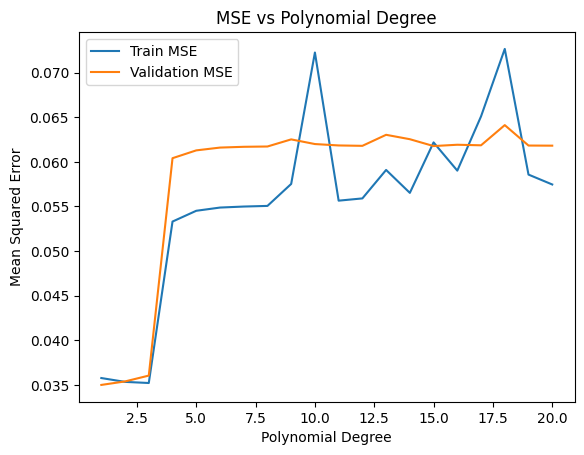

In [131]:
plt.plot(degrees, mse_train_arr, label='Train MSE')
plt.plot(degrees, mse_val_arr, label='Validation MSE')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

The lowest MSE with degree = 1. 
Select degree = 1 in test set

In [132]:
best_degree = 1
best_model = make_pipeline(PolynomialFeatures(degree = best_degree), LinearRegression())
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)

print('Test MSE ', mse_test)

Test MSE  0.04041954996144231


### Compare two model: according to MSE, single linear regression seem to be better than multi linear regression.

### Linear regression is not suitable for this dataset